In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zipf, norm, lognorm, poisson, expon
from scipy.stats import chisquare
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def simple_parameter_estimation(x):
    return 1 + len(x) / sum(np.log(x))


In [3]:
for i in range(0, 10):
    error = 0
    for j in range(1, 11):
        s = 1 + (i * 10 + j) / 100;
        sample = zipf.rvs(s, size=1000)
        s_hat = simple_parameter_estimation(sample)
        error += np.abs(s_hat - s)
    print('s =', 1 + i * 10 / 100, '..', 1 + (i + 1) * 10 / 100, 'error =', error / 10)


s = 1.0 .. 1.1 error = 0.018982871506377806
s = 1.1 .. 1.2 error = 0.015452001774085322
s = 1.2 .. 1.3 error = 0.040308386850302004
s = 1.3 .. 1.4 error = 0.08994615964437988
s = 1.4 .. 1.5 error = 0.15439126001492184
s = 1.5 .. 1.6 error = 0.207059161896528
s = 1.6 .. 1.7 error = 0.30540978362606425
s = 1.7 .. 1.8 error = 0.41605076837975774
s = 1.8 .. 1.9 error = 0.4949935980534059
s = 1.9 .. 2.0 error = 0.6696928608054851


In [4]:
def chisquare_test(sample):
    s_hat = simple_parameter_estimation(sample)
    if (s_hat < 1.1):
        s_hat = 1.1
    unique, counts = np.unique(np.ceil(sample).astype(int), return_counts=True)
    counts[::-1].sort()
    return chisquare(counts, np.ceil(len(sample) * zipf.pmf([i for i in range(1, len(counts) + 1)], s_hat)))[1]

tests = {'chi': chisquare_test}


In [5]:
def add_noise(sample, level, distrib, args):
    rand_values = np.random.rand(len(sample))
    for i in range(len(sample)):
        if rand_values[i] < level:
            sample[i] = distrib.rvs(*args)


In [6]:
pvalues_n = dict([(test, []) for test in tests])
sample_sizes = [i * 100000 for i in range(1, 10)]
s = 1.1
for n in sample_sizes:
    sample = zipf.rvs(s, size=n)
    for name in tests:
        pvalues_n[name].append(tests[name](sample))


<function matplotlib.pyplot.show(*args, **kw)>

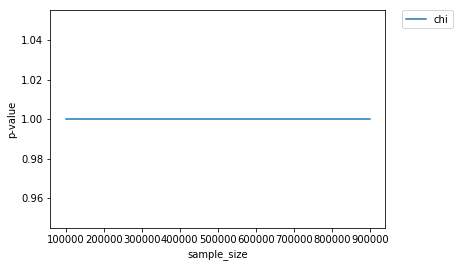

In [7]:
for name in tests:
    plt.plot(sample_sizes, pvalues_n[name], label=name)
plt.xlabel('sample_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show


In [8]:
pvalues_l = dict([(test, []) for test in tests])
noise_levels = [i / 100 for i in range(50)]
s = 1.1
n = 10000
for level in noise_levels:
    sample = zipf.rvs(s, size=n)
    add_noise(sample, level, lognorm, [1])
    for name in tests:
        pvalues_l[name].append(tests[name](sample))


<function matplotlib.pyplot.show(*args, **kw)>

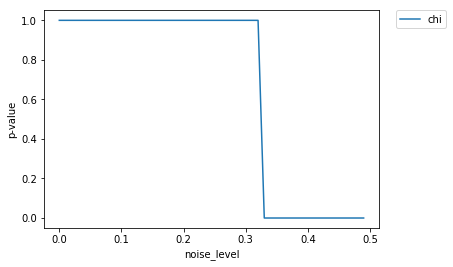

In [9]:
for name in tests:
    plt.plot(noise_levels, pvalues_l[name], label=name)
plt.xlabel('noise_level')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show


In [10]:
def get_false_positive(test, N=1000, s=1.1, sample_size=1000):
    false_positive = 0;
    for i in range(N):
        sample = zipf.rvs(s, size=sample_size)
        if test(sample) <= 0.05:
            false_positive += 1
    return false_positive / N

def get_true_negative(test, N=1000, sample_size=1000, distrib=lognorm, args=[1]):
    true_negative = 0;
    for i in range(N):
        sample = distrib.rvs(*args, size=sample_size)
        if test(sample) > 0.05:
            true_negative += 1
    return true_negative / N


In [11]:
print('false_positive')
for s in np.linspace(1.1, 2.0, num=10):
    for name in tests:
        print('s =', s)
        print(' ', name, get_false_positive(tests[name], s=s))


false_positive
s = 1.1
  chi 0.0
s = 1.2000000000000002
  chi 0.0
s = 1.3
  chi 0.0
s = 1.4000000000000001
  chi 0.0
s = 1.5
  chi 0.0
s = 1.6
  chi 0.003
s = 1.7000000000000002
  chi 0.327
s = 1.8
  chi 0.97
s = 1.9
  chi 1.0
s = 2.0
  chi 1.0


In [12]:
distribs = [('lognorm', lognorm, [10]),
            ('poisson', poisson, [1]),
            ('expon', expon, []), ]

print('true_negative')
for dist_name, dist, args in distribs:
    print(dist_name)
    for name in tests:
        print(' ', name, get_true_negative(tests[name], distrib=dist, args=args))


true_negative
lognorm
  chi 0.111
poisson
  chi 0.0
expon
  chi 0.0


<function matplotlib.pyplot.show(*args, **kw)>

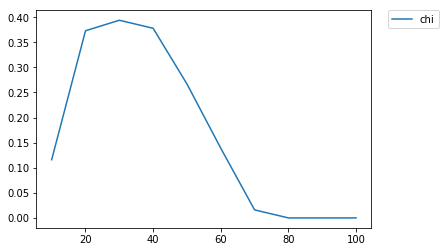

In [13]:
tn = []
for i in np.linspace(10, 100, 10):
    tn.append(get_true_negative(tests[name], distrib=lognorm, args=[i]))

for name in tests:
    plt.plot(np.linspace(10, 100, 10), tn, label=name)
plt.xlabel('')
plt.ylabel('true_negative')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show
